## Task 1: generate aberration with random PWM values

Use random PWM values with range (0,4095) to deform the mirror and create mirror surface with aberration. Take 10 images for the same PWM setting to make sure we have a stable enough image arrary to calculate the quality.

The original PWM randomly set by [831, 2829, 1071, 262, 2811].


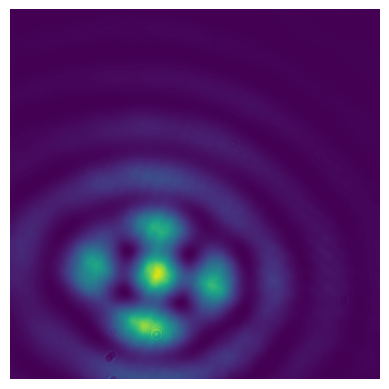

In [1]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
  
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner


import laserbeamsize as lbs
A = np.random.randint(low=0,high=4095,size=(5,1), dtype=np.int32)   # range form 0 to 3000
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A)
raw_image_array = cam.grab(10) # grab 10 frames
image_array_initial=np.array(raw_image_array)
squeezed_image_array=image_array_initial.squeeze()
random_PWM=A
random_PWM_printed=A.ravel().tolist()
print(f"The original PWM randomly set by {random_PWM_printed}.")
plt.axis('off')
plt.imshow(image_array_initial[0])
cam.close()

## Task 2: get the quality of initial focal spot image

First use the gaussian fitting method:

In [2]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)
def get_quality_number1(squeezed_image_array):
    score=[]
    for i in range (len(squeezed_image_array)):
        x=np.linspace(0,1000,1000)
        [m,n]=np.where(squeezed_image_array[i]==np.max(squeezed_image_array[i]))
        mode_info_m = stats.mode(m, keepdims=True)  ##col
        mode_info_n = stats.mode(n, keepdims=True) ##row
        a=int(mode_info_m[0])
        b=int(mode_info_n[0])
        c=5 #box half-thickness
        y_x=0

        for j in range (a-c,a+c):
            y_x=y_x+squeezed_image_array[i][j,:]/100 #tricky here since if this number is >255 it becomes 0.
        y_x=(y_x)/c*100

        y_y=0

        for j in range (b-c,b+c):
            y_y=y_y+squeezed_image_array[i][:,j]/100
        y_y=((y_y)/c)*100

        popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
        fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
        a_x=r2_score(y_x,fitted_y_x)
        popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
        fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
        a_y=r2_score(y_y,fitted_y_y)

        s=abs(a_x*a_y)
        score.append(s)
        average_score=np.mean(score)
    return average_score

s1=get_quality_number1(squeezed_image_array)
print(s1)

0.5149284133907868


use another distribution method:

In [3]:
import laserbeamsize as lbs

def get_quality_number2(squeezed_image_array):
    score=[]
    for i in range (len(squeezed_image_array)):
        x, y, dx, dy, phi = lbs.beam_size(squeezed_image_array[i])
        Ellipticity = min(dx, dy) / max(dx, dy)
        threshold_up_area = (squeezed_image_array[i] >= np.max(squeezed_image_array[i]) / 10) + 0  # define a threshold area
        total_pixel = squeezed_image_array[i].shape[0] * squeezed_image_array[i].shape[1]
        dispersion = total_pixel / np.sum(threshold_up_area)
        quality_number = dispersion * Ellipticity
        score.append(quality_number)
        average_score=np.mean(score)
    return average_score
s2=get_quality_number2(squeezed_image_array)
print(s2)

4.804678938898166


## Task 3: use bayesian optimisation to get the correction of aberration

In [4]:
from skopt import gp_minimize
import pygad
import laserbeamsize as lbs
import numpy as np

# Use the optimal_pwm_values for controlling the deformable mirror
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

def objective(solution):
    Score=[]
    A = np.array([[solution[0]], [solution[1]], [solution[2]], [solution[3]], [solution[4]]])
    A_printed=A.ravel().tolist()
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.1)
    raw_image_array = cam.grab(10) # grab 10 frames
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    quality_number = get_quality_number1(squeezed_image_array)
    score = -quality_number
    Score.append(quality_number)
    print(f"Image score with {A_printed} is {quality_number}")
    return score

bounds = [(0, 4095)] * 5  # Example bounds for 5 PWM values

# Modify the following parameters as per your requirements
n_calls = 30  # Number of iterations
n_points = 10  # Number of points used for training the surrogate model

res = gp_minimize(objective, bounds, n_calls=n_calls, n_points=n_points)

optimal_pwm_values = res.x
print(optimal_pwm_values)
print(res)
cam.close()

Image score with [2313, 3630, 717, 2693, 153] is 0.935376658705621
Image score with [515, 1904, 402, 3720, 3854] is 0.8953889698303747
Image score with [41, 2656, 2432, 763, 1515] is 0.8266834906428574
Image score with [3130, 1280, 3024, 456, 3042] is 0.8456803124467692
Image score with [2660, 1045, 2169, 2024, 1305] is 0.06859578458065463
Image score with [1170, 3150, 4071, 2149, 2959] is 0.5220564497803019
Image score with [1621, 569, 51, 1908, 3076] is 0.7155058487895534
Image score with [4060, 1549, 2904, 493, 1255] is 0.7899645922812177
Image score with [2950, 2333, 3012, 406, 2944] is 0.8014480814661008
Image score with [3013, 2593, 1051, 1777, 2863] is 0.28489492237112896
Image score with [3423, 3430, 62, 2996, 1055] is 0.8198416558877076
Image score with [466, 870, 1739, 3299, 0] is 0.7347432424928992
Image score with [1593, 2641, 0, 4095, 0] is 0.9757891534851622
Image score with [467, 2394, 0, 235, 4095] is 0.13216275580383355
Image score with [0, 4022, 243, 4095, 2514] is 0.

## Task 4: review the optimisation result

In [5]:
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
A0 = np.array([[random_PWM[0]], [random_PWM[1]], [random_PWM[2]], [random_PWM[3]], [random_PWM[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A0)
print(f"The original PWM randomly set by {random_PWM_printed} with score {s1}")

A1= np.array([[optimal_pwm_values[0]], [optimal_pwm_values[1]], [optimal_pwm_values[2]], [optimal_pwm_values[3]], [optimal_pwm_values[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A1)
raw_image_array1 = cam.grab(10) # grab 10 frames
image_array1=np.array(raw_image_array1)
squeezed_image_array1=image_array1.squeeze()
print(f"The suggested PWM values for correction is {optimal_pwm_values} with score {-res.fun}")
cam.close()

The original PWM randomly set by [831, 2829, 1071, 262, 2811] with score 0.5149284133907868
The suggested PWM values for correction is [1593, 2641, 0, 4095, 0] with score 0.9757891534851622


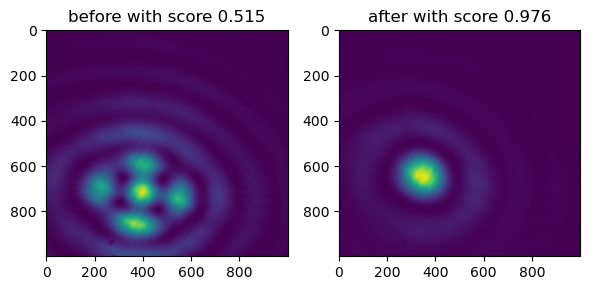

In [6]:
rows = 1
columns = 2
fig, (ax1, ax2) = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))
ax1.imshow(image_array_initial[0], aspect='auto')
ax1.set_title(f'before with score {s1:.3f}')
ax2.imshow(image_array1[0], aspect='auto')
ax2.set_title(f'after with score {-res.fun:.3f}')
fig.tight_layout() # used to adjust padding between subplots 


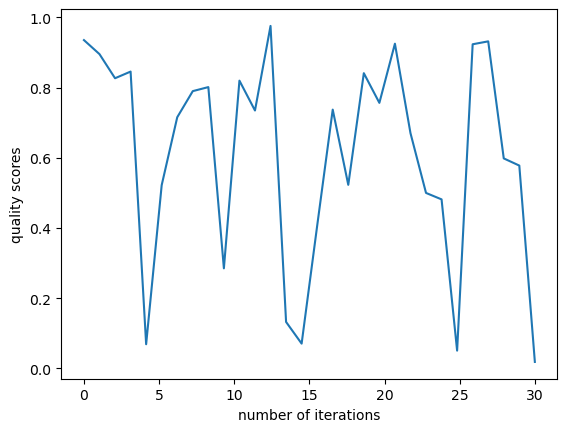

In [7]:
x=np.linspace(0,30,30)
plt.plot(x,-res.func_vals)
plt.xlabel('number of iterations')
plt.ylabel('quality scores')
plt.show()

### Now the time to enhance the quality analysis and optimisation loop. (It took around 3mins to run the whole jupyter notebook)